----------------------

<span style="font-size: 26px;"><b>Анализ данных сервиса аренды самокатов GoFast</b></span> 

Сервис аренды самокатов становится весьма популярным видом бизнеса. Для его развития необходим регулярный анализ и оценка условий рынка и эффективности используемых инструментов. В данном проекте оценивается влияние наличия или отсутствия подписки на параметры сессий и ежемесячную выручку. Также стоит задача оценки количества промокодов для привлечения определенного количества клиентов и задача оценки эффективности отправки определенного количества уведомлений клиентам.

Для проведения анализа нам предоставлено 3 датафрейма с данными о пользователях, поездках и подписках. В ходе работы мы изучим данные с датафреймов, проведем их предобработку, приведем к нужному типу данных, выявим пустые ячейки и удалим дубликаты при наличии. Далее обобщим информацию в виде графиков и проверим наличие выбросов. Сздадим сводный датафрейм с полной информацией о пользователях, их поездках и подписках, который разделим на два отдельных по принципу наличия или отсутствия подписки. Построим графики и сравним расстояния и  время поездок пользователей в зависимости от наличия подписки. Далее проведем рассчет ежемесячной выручки и проверим гипотезы  о влиянии наличия подписки на среднее время и расстояние поездок, а также на помесячную выручку от пользователей. Опишем порядок проверки гипотезы о влиянии обновления сервера на количество обращений в поддержку. Дополнительно решим задачу о необходимом количестве промокодов для привлечения определенного количества пользователей с заданной вероятностью. Также решим задачу о вероятности открытия push-уведомлений определенным числом пользователей, при заданном количестве планируемых к отправке уведомлений. Сделаем вывод о том выгодны ли пользователи с подпиской для компании.


In [1]:
from scipy import stats as st 
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

#### Шаг 1. Загрузка данных

Загружаем информацию о пользователях и выводим статистику и данные первых 10 строк

In [2]:
data_users = pd.read_csv('/datasets/users_go.csv')
data_users.info()
data_users.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


Загружаем информацию о поездках пользователей и выводим статистику и данные первых 10 строк

In [3]:
data_rides = pd.read_csv('/datasets/rides_go.csv')
data_rides.info()
data_rides.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


Загружаем информацию о подписках пользователей и выводим статистику и данные первых 10 строк

In [4]:
data_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
data_subscriptions.info()
data_subscriptions.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Данные полные, без пропусков. Названия столбцов корректны, типы данных соответствуют содержимому, кроме столбца даты. Надо привести столбец date к типу даты pandas. Из данных следует, что всего 1565 пользователей, совершивших суммарно 18068 поездок и имеющих 2 типа подписок.

#### Шаг 2. Предобработка данных

Приведем столбец date к типу даты pandas.

In [5]:
data_rides['date'] = pd.to_datetime(data_rides['date'], format='%Y-%m-%d')# перевод даты первой публикации в формат datetime64 
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Проверим за какой период присутствуют данные в датасете.

In [6]:
print('Минимальная дата:', data_rides['date'].min())
print('Максимальная дата:', data_rides['date'].max())

Минимальная дата: 2021-01-01 00:00:00
Максимальная дата: 2021-12-30 00:00:00


Все данные о поездках только за 2021 год.

Добавим столбец с номером месяца в датасет поездок.

In [7]:
data_rides['month'] = data_rides['date'].dt.month

Проверим возможность наличия неявных дубликатов. Для этого проверим колонку городов в датасете данных пользователей.

In [8]:
print(*data_users['city'].sort_values().unique(), sep="\n", end="\n\n") # сортировка таблицы по наименования,
                                                                        #получение уникальных значений населенного пункта и вывод списка в виде столбца

Екатеринбург
Краснодар
Москва
Омск
Пятигорск
Ростов-на-Дону
Сочи
Тюмень



Неявных дубликатов нет.

Проверим наличие дубликатов в датасетах с данными пользователец и поездок.

In [9]:
data_users.duplicated().sum()

31

In [10]:
data_rides.duplicated().sum()

0

Удалим дубликаты из датасета с данными пользователей.

In [11]:
data_users = data_users.drop_duplicates().reset_index(drop=True)
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 60.0+ KB


Дубликаты удалены, количество пользователей уменьшилось на 31.

#### Шаг 3. Исследовательский анализ данных

Построим графики из датафреймов для обобщения информации и выявления наличие локальных выбросов.

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

''

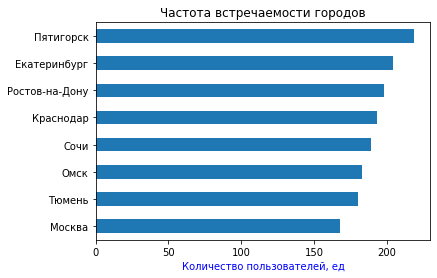

In [12]:
ax = data_users['city'].value_counts(ascending=True).plot.barh(title="Частота встречаемости городов")
plt.xlabel("Количество пользователей, ед", fontsize=10, color='blue')
display(data_users['city'].value_counts(sort=True))
""

In [13]:
display(data_users['city'].value_counts(sort=True))

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

''

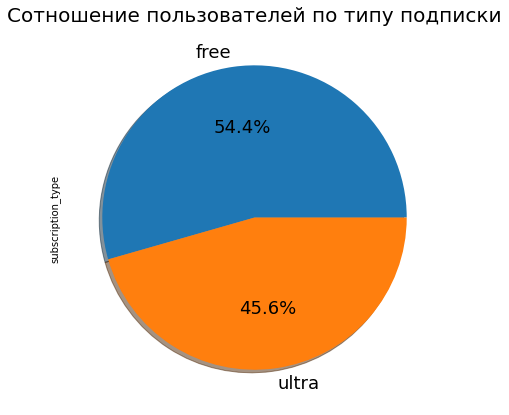

In [14]:
data_users['subscription_type'].value_counts().plot.pie(
    autopct='%1.1f%%',
    shadow=True,
    figsize=(7, 7),
    fontsize=18
)
plt.title('Сотношение пользователей по типу подписки', fontsize=20)

""

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

''

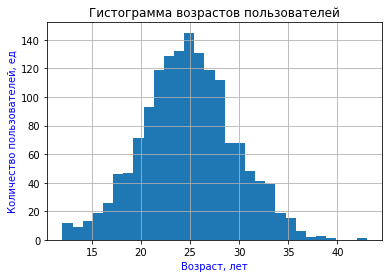

In [15]:
data_users['age'].hist(bins=30, figsize=(6, 4))
plt.title('Гистограмма возрастов пользователей')
plt.xlabel("Возраст, лет", fontsize=10, color='blue')
plt.ylabel("Количество пользователей, ед", fontsize=10, color='blue')
display(data_users['age'].describe())
""

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

''

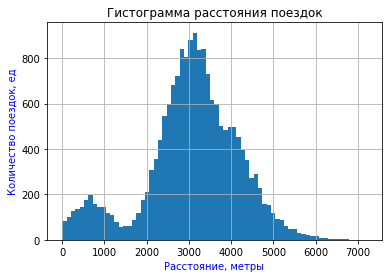

In [16]:
data_rides['distance'].hist(bins=70, figsize=(6, 4))
plt.title('Гистограмма расстояния поездок')
plt.xlabel("Расстояние, метры", fontsize=10, color='blue')
plt.ylabel("Количество поездок, ед", fontsize=10, color='blue')
display(data_rides['distance'].describe())
""

Посмотрим данные по первому небольшому пику, для этого отсортируем таблицу поездок по расстоянию менее 1500 метров.

In [17]:
test = data_rides[data_rides['distance'] < 1500]
display(test.head(20))
test.info()

,user_id,distance,duration,date,month
2,1,754.159807,6.232113,2021-04-20,4
9,1,748.690645,15.041884,2021-11-22,11
20,2,923.007439,6.914760,2021-08-03,8
47,4,724.559572,11.811399,2021-11-14,11
91,9,979.657684,17.521497,2021-03-08,3
100,10,680.952663,5.150377,2021-02-21,2
105,10,1409.589386,15.020549,2021-07-02,7
121,12,1236.815996,9.710448,2021-08-07,8
132,13,1158.851148,7.345692,2021-10-26,10
149,15,634.891669,15.809350,2021-04-05,4


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1796 entries, 2 to 18058
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   1796 non-null   int64         
 1   distance  1796 non-null   float64       
 2   duration  1796 non-null   float64       
 3   date      1796 non-null   datetime64[ns]
 4   month     1796 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 84.2 KB


count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

''

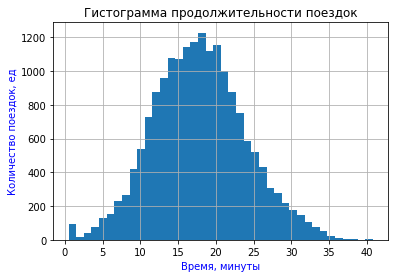

In [18]:
data_rides['duration'].hist(bins=40, figsize=(6, 4))
plt.title('Гистограмма продолжительности поездок')
plt.xlabel("Время, минуты", fontsize=10, color='blue')
plt.ylabel("Количество поездок, ед", fontsize=10, color='blue')
display(data_rides['duration'].describe())
""

Проверим скачок с временем поездки около 0 минут. Для этого отсортируем датафрейм с поездками по времени от 0 до 2 мин.

In [19]:
test = data_rides[data_rides['duration'] < 2]
display(test.head(10))
test.info()

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
6860,724,6225.520342,0.5,2021-12-16,12
6883,726,4452.491518,0.5,2021-03-01,3
7018,735,4406.954812,0.5,2021-04-13,4
7160,745,5286.167732,0.5,2021-08-17,8
7364,760,4881.391865,0.5,2021-08-29,8


<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 6531 to 17909
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   95 non-null     int64         
 1   distance  95 non-null     float64       
 2   duration  95 non-null     float64       
 3   date      95 non-null     datetime64[ns]
 4   month     95 non-null     int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 4.5 KB


Видны аномальные значения расстояния, не соответствующие времени сессии. За 2 минуты при макимальной скорсти 25 км/ч не может проехать больше 1000 метров. Таких поездок менее 1%, их удаление не повлияет на качество дальнейшего анализа. Удалим сессии с временем  менее 2 мин и расстоянием более 1000 м.

In [20]:
data_rides = data_rides.drop(data_rides[(data_rides['duration'] < 2) & (data_rides['distance'] > 1000)].index)
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   17973 non-null  int64         
 1   distance  17973 non-null  float64       
 2   duration  17973 non-null  float64       
 3   date      17973 non-null  datetime64[ns]
 4   month     17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 842.5 KB


Выбросы в данных убраны, количество сессий стало равным 17973. Наибольшое число пользователей из Пятигорска, в среднем из каждого города по 150-200 пользователей. Пользователей без подписки больше, но не сильно значительно. Средний возраст пользователей составляет 25 лет, средние расстояние и время поездки составляют 3100 метров и 18 мин соответственно. Есть локальный сегмент с короткими поездками в среднем окло 700 метров, возможно до метро или магазинов.

#### Шаг 4. Объединение данных

Обьеденим все 3 датафрейма в один, bспользуем метод merge().

In [21]:
data_all = data_rides.merge(data_users, on='user_id')
data_all = data_all.merge(data_subscriptions, on='subscription_type')
display(data_all.head(10))
data_all.info()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
5,1,2770.890808,16.650138,2021-10-09,10,Кира,22,Тюмень,ultra,6,0,199
6,1,3039.020292,14.927879,2021-10-19,10,Кира,22,Тюмень,ultra,6,0,199
7,1,2842.118050,23.117468,2021-11-06,11,Кира,22,Тюмень,ultra,6,0,199
8,1,3412.690668,15.238072,2021-11-14,11,Кира,22,Тюмень,ultra,6,0,199
9,1,748.690645,15.041884,2021-11-22,11,Кира,22,Тюмень,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   distance           17973 non-null  float64       
 2   duration           17973 non-null  float64       
 3   date               17973 non-null  datetime64[ns]
 4   month              17973 non-null  int64         
 5   name               17973 non-null  object        
 6   age                17973 non-null  int64         
 7   city               17973 non-null  object        
 8   subscription_type  17973 non-null  object        
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Обьединение датафреймов проведено корректно, количество сессий после обьединения равно исходным данным.

Рзобьем датафрейм на 2 категории "С подпиской" и " Без подписки".

In [22]:
data_subscription_free = data_all.loc[data_all['subscription_type'] == 'free'] # Выделение пользователей без подписки в отдельный dataframe
data_subscription_ultra = data_all.loc[data_all['subscription_type'] == 'ultra'] # Выделение пользователей c подпиской в отдельный dataframe
print('Free')
data_subscription_free.info()
display(data_subscription_free[['duration', 'distance', 'age']].describe())
print('\nUltra')
data_subscription_ultra.info()
display(data_subscription_ultra[['duration', 'distance', 'age']].describe())

Free
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11473 entries, 6500 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11473 non-null  int64         
 1   distance           11473 non-null  float64       
 2   duration           11473 non-null  float64       
 3   date               11473 non-null  datetime64[ns]
 4   month              11473 non-null  int64         
 5   name               11473 non-null  object        
 6   age                11473 non-null  int64         
 7   city               11473 non-null  object        
 8   subscription_type  11473 non-null  object        
 9   minute_price       11473 non-null  int64         
 10  start_ride_price   11473 non-null  int64         
 11  subscription_fee   11473 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB


,duration,distance,age
count,11473.000000,11473.000000,11473.000000
mean,17.530771,3028.374239,24.888782
std,6.162609,1235.541051,4.482066
min,2.035632,0.855683,12.000000
25%,13.085688,2360.878149,22.000000
50%,17.383807,3102.083025,25.000000
75%,21.638038,3883.979311,28.000000
max,34.948498,7066.003772,43.000000



Ultra
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   distance           6500 non-null   float64       
 2   duration           6500 non-null   float64       
 3   date               6500 non-null   datetime64[ns]
 4   month              6500 non-null   int64         
 5   name               6500 non-null   object        
 6   age                6500 non-null   int64         
 7   city               6500 non-null   object        
 8   subscription_type  6500 non-null   object        
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB


,duration,distance,age
count,6500.000000,6500.000000,6500.000000
mean,18.541985,3115.445388,24.892615
std,5.572048,836.895330,4.757208
min,3.760353,244.210438,12.000000
25%,14.524654,2785.444017,22.000000
50%,18.178153,3148.637229,25.000000
75%,21.884129,3560.574425,28.000000
max,40.823963,5699.769662,38.000000


Создадим гистограммы расстояния и времени  поездок для пользователей без подписки и с подпиской.

''

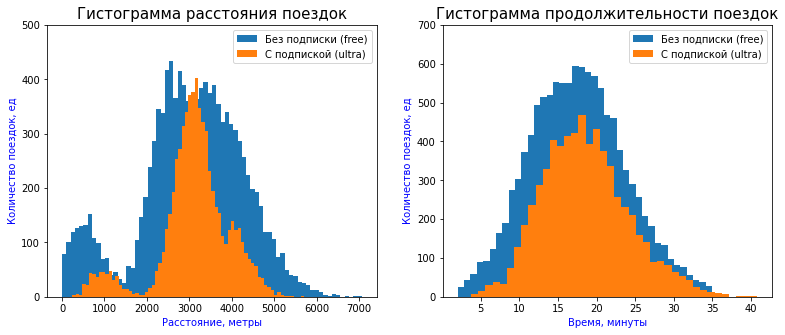

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

axs[0].hist([data_subscription_free ['distance']], bins=70, label='Без подписки (free)')
axs[0].hist([data_subscription_ultra ['distance']], bins=70, label='С подпиской (ultra)')
axs[0].set_title('Гистограмма расстояния поездок', fontsize=15)
axs[0].set_xlabel("Расстояние, метры", fontsize=10, color='blue')
axs[0].set_ylabel("Количество поездок, ед", fontsize=10, color='blue')
axs[0].set_ylim([0,500])
axs[0].legend()
axs[1].hist( [data_subscription_free ['duration']], bins=40, label='Без подписки (free)')
axs[1].hist( [data_subscription_ultra ['duration']], bins=40, label='С подпиской (ultra)')
axs[1].set_title('Гистограмма продолжительности поездок', fontsize=15)
axs[1].set_xlabel("Время, минуты", fontsize=10, color='blue')
axs[1].set_ylabel("Количество поездок, ед", fontsize=10, color='blue')
axs[1].set_ylim([0,700])
axs[1].legend()

plt.show

""

В целом гистограммы по пользователям с подпиской и без нее похожи. На гистограмме рассояния поездок с подпской (ultra)  присутствует дополнительное локальное пиковое значение с длительными поездками, это может быть связано с более низкой стоимостью минут сессии по подписке. Также данная гистограмма более усредненная у среднего значения, т.е. имеет меньшую дисперсию.

#### Шаг 5. Подсчёт выручки

Проверим наличие пользоватлей, которые делали поезди с подпиской и без нее. Для это проверим присутсвие id из датафрейма data_subscription_ultra в датафрейме data_subscription_free.

In [24]:
n = 0
for index, row in data_subscription_ultra.iterrows():
    if data_subscription_ultra.loc[index,'user_id'] in data_subscription_free['user_id'].values:
        n += 1
if n == 0:
    print('Пользователи использовавшие сервис в течении года с подпиской и без нее не обнаружены')
else:
    print('Есть пользователи использовавшие сервис в течении года с подпиской и без нее')

Пользователи использовавшие сервис в течении года с подпиской и без нее не обнаружены


Округлим значения времени каждой сессии в таблице данных в сторону большего целого. Также округлим значения расстояния каждой сессии в таблице данных по банковским правилам. Создадим агрегированную по пользователям и месяцам таблицу сумарного количества, расстояния и времени поездок.

In [25]:
data_all_rounded = data_all
data_all_rounded['duration'] = np.ceil(data_all_rounded['duration'])# округляем времяя поездок в сторону большего целого
data_all_rounded['distance'] = round(data_all_rounded['distance'])# округляем расстояние поездок по банковским правилам
data_all_rounded['duration'] = data_all_rounded['duration'].astype(int) 
data_all_rounded['distance'] = data_all_rounded['distance'].astype(int)

agg_func = {'distance': ['count', 'sum'], 'duration': ['sum']}  #создаем словарь с функциями и столбцами к которым их надо применить
data_all_sum_id_by_month = data_all_rounded.pivot_table(
                            index = ['user_id', 'month', 'subscription_type'], 
                            values=['distance', 'duration'], 
                            aggfunc = agg_func
                            ).reset_index() # создаем сводную таблицу и сбрасываем индексы
data_all_sum_id_by_month.columns = ['user_id', 'month', 'subscription_type', 'ride_counts', 'distance', 'duration'] # изменяем названия столбцов

data_all_sum_id_by_month = data_all_sum_id_by_month.merge(data_subscriptions, on='subscription_type') #добавляем информацию по тарифам 

data_all_sum_id_by_month['revenue'] = (data_all_sum_id_by_month['start_ride_price'] * data_all_sum_id_by_month['ride_counts'] 
                                       + data_all_sum_id_by_month['minute_price'] * data_all_sum_id_by_month['duration'] 
                                       + data_all_sum_id_by_month['subscription_fee']
) # рассчитываем помесячную выручку 

data_all_sum_id_by_month.head(10)


,user_id,month,subscription_type,ride_counts,distance,duration,minute_price,start_ride_price,subscription_fee,revenue
0,1,1,ultra,2,7028,42,6,0,199,451
1,1,4,ultra,1,754,7,6,0,199,241
2,1,8,ultra,2,6724,46,6,0,199,475
3,1,10,ultra,2,5810,32,6,0,199,391
4,1,11,ultra,3,7004,56,6,0,199,535
5,1,12,ultra,2,6752,28,6,0,199,367
6,2,3,ultra,3,10188,63,6,0,199,577
7,2,4,ultra,2,6165,40,6,0,199,439
8,2,6,ultra,1,3255,14,6,0,199,283
9,2,7,ultra,2,6781,48,6,0,199,487


#### Шаг 6. Проверка гипотез

<span style="font-size: 14px;"><b>6.1 Влияние наличия подписки на время сессии </b></span>

Сформулируем нулевую гипотезу так: Пользователи с подпиской (ultra) и без подписки (free) тратят одинаковое среднее  времени на поездки. 

Альтернативная гипотеза будет левосторонней:  Пользователи с подпиской (ultra) в среднем тратят больше времени на поездки.

In [26]:
alpha = 0.05# уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(data_subscription_ultra['duration'], data_subscription_free['duration'], equal_var=False, alternative='greater')

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-value: 1.6162210195311063e-29
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута, пользователи с подпиской (ultra) в среднем тратят больше времени на поездки.

<span style="font-size: 14px;"><b>6.2 Влияние наличия подписки на расстояние, коорое проезжают пользователи </b></span>

Сформулируем нулевую гипотезу так: Пользователи с подпиской (ultra) в среднем проезжают расстояние равное 3130 метров. 

Альтернативная гипотеза будет левосторонней:  Пользователи с подпиской (ultra) в среднем проезжают расстояние больше 3130 метров.

In [27]:
target_value = 3130

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(
    data_subscription_ultra['distance'], 
    target_value,
      alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


Нулевая гипотеза не отвергнута, значит с высокой вероятностю пользователи с подпиской (ultra) в среднем проезжают не более 3130 метров.

<span style="font-size: 14px;"><b>6.3 Влияние наличия подписки на помесячную выручку </b></span>

Сформулируем нулевую гипотезу так: Пользователи с подпиской (ultra) и без подписки в среднем приносят одинаковую помесячную выручку. 

Альтернативная гипотеза будет левосторонней:  Пользователи с подпиской (ultra) в среднем приносят большую помесячную выручку чем пользователи без подписки (free).

In [28]:
alpha = 0.05# уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(
    data_all_sum_id_by_month['revenue'][data_all_sum_id_by_month['subscription_type'] == 'ultra'],
    data_all_sum_id_by_month['revenue'][data_all_sum_id_by_month['subscription_type'] == 'free'], 
    equal_var=False, 
    alternative='greater'
)

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-value: 2.4970242872858465e-38
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута, значит пользователи с подпиской (ultra) приносят большую помесячную выручку в сравнении с пользователями без подписки (free).

<span style="font-size: 14px;"><b>6.4 Влияние обновления сервера на количество обращений</b></span>

При наличии датасета с количеством обращений пользователей до и после обновления, было бы необходимо выполнить проверку гипотезы о равенстве средних для зависимых (парных) выборок. Для этого надо применить метод scipy.stats.ttest_rel() и использовать параметр alternative='greater'. Если нулевая гипотеза будет отброшена, это будет означать, что с высокой вероятностью обращений до обновления сервера было больше чем после.

#### Шаг 7. Распределения

<span style="font-size: 14px;"><b>7.1 Промокоды </b></span>

Для решения задачи с необходимым количеством промокодов необходимо воспользоваться биноминальным распределением. Для начала построим график для 1000 попыток эксперимента бернули. 

/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


''

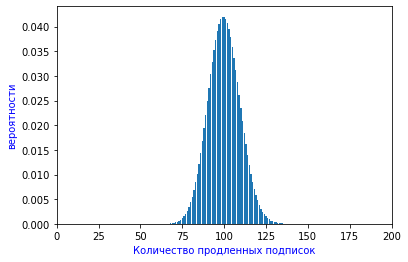

In [29]:


n = 1000 # количество промокодов
p = 0.1 # вероятность успеха

distr = []

for k in range(0, n + 1):
    current_value = st.binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr)
plt.xlim([0, 200])
plt.xlabel("Количество продленных подписок", fontsize=10, color='blue')
plt.ylabel("вероятности", fontsize=10, color='blue')
plt.show
''


Видно что при 1000 промокодах вероятность привлечь 100 и более клиентов примерно 50 %. Значит нам потребуется больше 1000 промокодов.
Построим график биноминального распределения при 1200 промокодах.

''

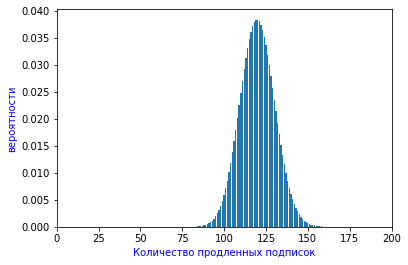

In [30]:
n = 1200 # количество промокодов
p = 0.1 # вероятность успеха

distr = []

for k in range(0, n + 1):
    current_value = st.binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr)
plt.xlim([0, 200])
plt.xlabel("Количество продленных подписок", fontsize=10, color='blue')
plt.ylabel("вероятности", fontsize=10, color='blue')
plt.show
''

По графику плотности вероятности, с помощью метода cdf() подберем такое колоичество промокодов, чтоб вероятность набрать меньше 100 клиентов была примерно равна 0.05.

In [31]:
alpha = 0.05 # верхняя граница вероятности неудачи

p = 0.1 # вероятность успеха

for n in range(1000, 1201):
    current_value = st.binom.cdf(100, n, p)
    if current_value < alpha:
        print('Нужно', n, 'промокодов')
        break
    

Нужно 1172 промокодов


Исходя из графиков биноминального распределения мы определили, что количество промокодов необходимых для получения 100 пользователей  с вероятностью 95% равняется примерно 1000-1200 шт. Далее используя функцию биноминального распределения, воспользовавшись методом cdf() и перебрав значения в промежутке 1000-1200 выяснили, что для привлечения 100 пользователей с вероятностью 95% необходимо раздать не менее 1172 промокодов.

<span style="font-size: 14px;"><b>7.2 Push-уведомления </b></span>

Так как значение n (количество промокодов) достаточно большое, можно провести апроксимацию нормальным распределением. С помощью библиотеки seaborn построим примерный рафик распределения вероятностей. С помощью функции cdf() определим какая вероятность того, что уведомление не откроют менее 399,5 тыс. пользователей.

Вероятность того, что сообщение не откроют равна 0.15371708296369768


''

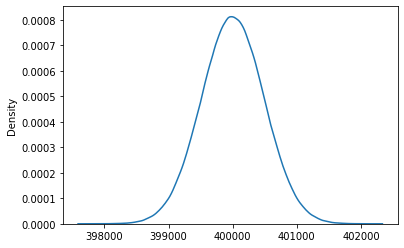

In [32]:


n = 1000000 # количество уведомлений
p = 0.4 # вероятность успеха

mu = n * p # рассчитайте параметры 
sigma = sqrt(n * p * (1 - p)) # нормального распределения
distr = st.norm(mu, sigma)

sns.kdeplot(distr.rvs(n))

print('Вероятность того, что сообщение не откроют равна', distr.cdf(399500))

''



Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей составляет около 15%.

Дополнительно оценим сколько надо расослать push-уведомлений для того чтоб их открыло 1172 клиента с вероятностью не менее 95%.

In [33]:
alpha = 0.05 # количество уведомлений
p = 0.4 # вероятность успеха

for n in range(2000, 5000):
    mu = n * p # рассчитайте параметры 
    sigma = sqrt(n * p * (1 - p)) # нормального распределения
    distr = st.norm(mu, sigma)
    if distr.cdf(1172) < alpha:
        print('Нужно', n, 'уведомлений')
        break


Нужно 3042 уведомлений


#### Общий вывод

<span style="font-size: 18px;"><u><i>Задачей данного исследования было проанализировать данные сервиса аренды самокатов GoFast и проверьте некоторые гипотезы связанные с наличием платной подписки. Также дополнительно надо было оценить необходимое количество промокодов для достижения необходиых результатов акции и оценить вероятность открытия уведомлений определенным количеством пользователей. Было проведено исследование 3 датафреймов с сервиса аренды самокатов GoFast, данные насчитывали 1534 пользователя и 18068 сессий.
</u></i>  </span>

<span style="font-size: 18px;"><i> В ходе выполнения исследования были выполнены следующие действия: </i></span> 
<span style="font-size: 18px;"><i>
1. Изучена общая информация из 3 датафреймов по пользователям, поездкам и типам подписок;
2. Столбец с датами поездок приведен к формату datetime64. Для проведения дальнейшего анализа на ежемесячную выручку добавлен столбец с месяцем поездок. Выявлены и удалены дубликаты (всего 35) в датафрейме с данными пользователей.
3. Оценена и визуализированна общая информация о: 
    частоте встречаемости городов; соотношении пользователей с подпиской и без подписки; 
    возрасте пользователей; 
    расстоянии, которое пользователь преодолел за одну поездку; 
    продолжительности поездок.
4. Объедините данные о пользователях, поездках и подписках в один датафрейм. Из обьединенного датафрейма созданы два отдельных датафрейма по категориям с подпиской и без подписки.  Визуализирована информация о расстоянии и времени поездок для пользователей обеих категорий.
5. Создана сводная таблица с данными о суммарном расстоянии, количестве поездок и суммарном времени для каждого пользователя за каждый месяц.
6. Были проверены гипотезы о влиянии наличия подписки на среднее время и расстояние поездок, а также на помесячную выручку от пользователей. Был описан порядок проверки гипотезы о влиянии обновления сервера на количество обращений в поддержку.
7. Дополнительно решена задача о необходимом количестве промокодов для привлечения определенного количества пользователей с заданной вероятностью. Также решена задача о вероятности открытия push-уведомлений определенным числом пользователей, при заданном количестве планируемых к отправке уведомлений.
9. Подготовлен общий вывод.
</i></span>

<span style="font-size: 22px;"><u><i> Вывод:</i>  </span>
    
1. Выявлено что пользователи с подпиской (ultra) в среднем тратят больше времени на поездки, проезжают не более 3130 метров за одну сессию, но приносят помесячную выручку больше чем прользователи без подписки (free). 
    
    
2. Для оценки гипотезы об уменьшении обращений в поддержку после обновления сервера, необходимо  выполнить проверку равенства средних для зависимых (парных) выборок. Для этого надо применить метод scipy.stats.ttest_rel() и использовать параметр alternative='greater'. Если нулевая гипотеза будет отброшена, это будет означать, что с высокой вероятностью обращений до обновления сервера было больше чем после.
    
    
3. Рассчитано, что при 10% вероятности продления подписки для того чтобы не менее 100 пользователей продлили подписку после бесплатного периода с вероятностью не менее 95%, необходимо раздать не менее 1172 промокодов.
    
    
4. При вероятности открытия сообщений пользователем в 40%, если разошлют 1 млн push-увеломлений, то вероятность их открытия числом людей менее 399.5 тыс. составляет 15%.
    
    
    
    
<span style="font-size: 22px;"><u><i> Рекомендации:</i>  </span>
    
Пользователи с подпиской являются более выгодными для компании. Необходимо сфокусировать усилия на привлечении беольшего числа  новых пользователей с подпиской и побуждении имеющихся пользователей к ее покупке. Для этих целей мжно провести акцию с раздачей большого числа промокодов (ориентировочно из расчета 1172 промокода для увеличения на каждых 100 клиентов с подпиской) и рассылкой push-уведомлений (около 3042 для того чтобы 1172 человека узнали о получении промокода с вероятностью более 90 %).